# ---------- 3. Load & Clean Data ----------
Data loaded and cleaned. Total records: 7043

# ---------- 4. Define Features & Split Data ----------
Data split into training and test sets.

# ---------- 5. Create Preprocessing & Modeling Pipelines ----------
Logistic Regression pipeline created successfully.

# ---------- 7. Train Models with GridSearchCV ----------
Training Logistic Regression...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13916\3733357129.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)
d:\MACHINE_LEARNING\LR_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead o

Model training complete.

# ---------- 8. Evaluate Model & Create Metrics Table ----------

=== Test Metrics ===
              Model  Accuracy  Churn Precision  Churn Recall  Churn F1-Score
Logistic Regression    0.7417           0.5087        0.7861          0.6176


# ---------- 9. Save Model and Results ----------
Best model: Logistic Regression -> churn_model.joblib
Saved model, model_columns.joblib, and evaluation_results.json

# ---------- 10. Plot Confusion Matrix ----------
Displaying confusion matrix plot...


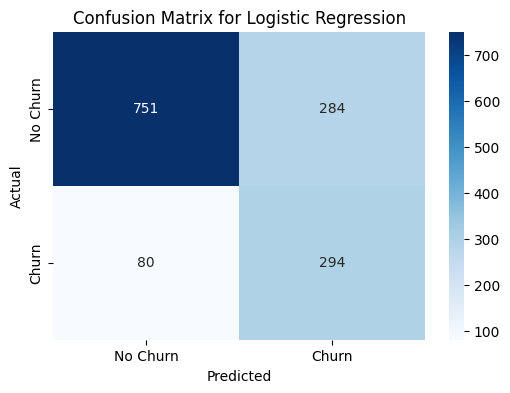


--- Model evaluation on TEST set ---
              precision    recall  f1-score   support

    No Churn       0.90      0.73      0.80      1035
       Churn       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409


--- Model evaluation on TRAIN set ---
              precision    recall  f1-score   support

    No Churn       0.91      0.74      0.81      4139
       Churn       0.52      0.80      0.63      1495

    accuracy                           0.75      5634
   macro avg       0.72      0.77      0.72      5634
weighted avg       0.81      0.75      0.77      5634



In [2]:
# ---------- 1. Import Libraries ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------- 2. Helper Functions ----------
def evaluate_classification_metrics(y_true, y_pred, name):
    """Calculates key metrics and returns them as a dictionary."""
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    churn_metrics = report.get('1', {}) # '1' is the label for Churn
    return {
        "Model": name,
        "Accuracy": report.get('accuracy'),
        "Churn Precision": churn_metrics.get('precision'),
        "Churn Recall": churn_metrics.get('recall'),
        "Churn F1-Score": churn_metrics.get('f1-score')
    }

def pretty_print_report(y_true, y_pred):
    """Prints a full classification report."""
    print(classification_report(y_true, y_pred, target_names=['No Churn', 'Churn']))

# ---------- 3. Load & Clean Data ----------
print("# ---------- 3. Load & Clean Data ----------")
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.columns = [c.strip() for c in df.columns]
target = 'Churn'
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df[target] = df[target].apply(lambda x: 1 if x == 'Yes' else 0)
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)
print(f"Data loaded and cleaned. Total records: {len(df)}\n")

# ---------- 4. Define Features & Split Data ----------
print("# ---------- 4. Define Features & Split Data ----------")
features = [col for col in df.columns if col != target]
X = df[features].copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Data split into training and test sets.\n")

# ---------- 5. Create Preprocessing & Modeling Pipelines ----------
print("# ---------- 5. Create Preprocessing & Modeling Pipelines ----------")
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
print("Logistic Regression pipeline created successfully.\n")

# ---------- 6. Define Hyperparameter Grids ----------
grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__class_weight': ['balanced']
}

# ---------- 7. Train Model with GridSearchCV ----------
print("# ---------- 7. Train Models with GridSearchCV ----------")
print("Training Logistic Regression...")
gs_lr = GridSearchCV(pipe_lr, grid_lr, cv=5, scoring='f1', n_jobs=-1)
gs_lr.fit(X_train, y_train)
best_model = gs_lr.best_estimator_
print("Model training complete.\n")


# ---------- 8. Evaluate Model & Create Metrics Table ----------
print("# ---------- 8. Evaluate Model & Create Metrics Table ----------")
y_pred = best_model.predict(X_test)
m = evaluate_classification_metrics(y_test, y_pred, "Logistic Regression")
metrics_df = pd.DataFrame([m])

print("\n=== Test Metrics ===")
print(metrics_df.to_string(index=False, float_format="{:.4f}".format))
print("\n")

# ---------- 9. Save Model and Results ----------
print("# ---------- 9. Save Model and Results ----------")
best_model_name = "Logistic Regression"
joblib.dump(best_model, "churn_model.joblib")
joblib.dump(list(X_train.columns), "model_columns.joblib")
report_dict = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)
evaluation_results = {
    'accuracy': accuracy,
    'classification_report': report_dict,
    'best_model_name': best_model_name
}
with open('evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)
print(f"Best model: {best_model_name} -> churn_model.joblib")
print("Saved model, model_columns.joblib, and evaluation_results.json\n")


# ---------- 10. Plot Confusion Matrix ----------
print("# ---------- 10. Plot Confusion Matrix ----------")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
print("Displaying confusion matrix plot...")
plt.show()


# ---------- Extra: Detailed Reports (Test vs. Train) ----------
print("\n--- Model evaluation on TEST set ---")
pretty_print_report(y_test, best_model.predict(X_test))
print("\n--- Model evaluation on TRAIN set ---")
pretty_print_report(y_train, best_model.predict(X_train))

